# Using Parameter Tuning

## Modules

In [1]:
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For data visualization

# For splitting data into train and test sets and performing hyperparameter tuning using cross-validation
from sklearn.model_selection import train_test_split, GridSearchCV  

# For scaling the features in the dataset
from sklearn.preprocessing import StandardScaler  

# For building a machine learning pipeline
from sklearn.pipeline import Pipeline  

# For building decision tree models and plotting the trees
from sklearn.tree import DecisionTreeClassifier, plot_tree  

# For computing performance metrics
from sklearn.metrics import confusion_matrix, classification_report  

## Data

In [2]:
# Load the iris dataset from uci
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                   header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
print(iris.head())

   sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa


In [3]:
# Splitting into features and target variable
X = iris.drop('class', axis=1)
y = iris['class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f"Training set :{X_train.shape}\nTesting set :{X_test.shape}\n")

Training set :(120, 4)
Testing set :(30, 4)



## Parameter Tuning

In [4]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()), # apply standard scaling to features
    ('clf', DecisionTreeClassifier(criterion = "gini", class_weight=None, random_state=100)) # decision tree classifier
])

# Define the hyperparameters to tune
param_grid = {
    'clf__max_depth': [2, 3, 4, 5], # maximum depth of the decision tree
    # set the max_depth hyperparameter for the clf sub-step of the pipeline
    # using clf__max_depth instead of clf max_depth helps to avoid syntax errors
    
    'clf__min_samples_split': [2, 5, 10], # minimum number of samples required to split an internal node
    
    'clf__min_samples_leaf': [1, 2, 4], # minimum number of samples required to be at a leaf node
    
    'clf__max_features': ['sqrt', 'log2', None], # number of features to consider when looking for the best split
    # The value None means that all features will be considered
    # The value sqrt means that square root of the number of features will be considered
    # The value log2 means that base-2 logarithm of the number of features will be considered
    
    'clf__ccp_alpha': [0.0, 0.01, 0.1, 1.0] # complexity parameter for cost complexity pruning
    # Greater values of ccp_alpha increase the number of nodes pruned
    # https://scikit-learn.org/stable/modules/tree.html#minimal-cost-complexity-pruning
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
    pipeline, 
    param_grid=param_grid, 
    cv=5,          # number of folds to be used in cross-validation
    n_jobs=-1      # - 1 to use all available cores on the machine
)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
best_patameters = grid_search.best_params_
print('Best hyperparameters:', pd.DataFrame.from_dict(best_patameters, orient='index', columns=['']))

Best hyperparameters:                            
clf__ccp_alpha          0.0
clf__max_depth          3.0
clf__max_features       NaN
clf__min_samples_leaf   2.0
clf__min_samples_split  2.0


## Model Evaluation

In [5]:
# Evaluate the model on the test set
y_pred = grid_search.predict(X_test)
print(f"\nAccuracy: {round(grid_search.score(X_test, y_test)*100, 2)}%")


Accuracy: 96.67%


In [6]:
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred))


Confusion matrix:
[[11  0  0]
 [ 0  5  1]
 [ 0  0 13]]


In [7]:
print('\nClassification report:')
print(classification_report(y_test, y_pred))


Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      0.83      0.91         6
 Iris-virginica       0.93      1.00      0.96        13

       accuracy                           0.97        30
      macro avg       0.98      0.94      0.96        30
   weighted avg       0.97      0.97      0.97        30



The classification report is a summary of the performance of the classification model on the test set. It includes several metrics such as precision, recall, and F1-score for each class, as well as an overall accuracy metric.


**Precision** is the proportion of true positive predictions (correctly predicted positive samples) among all positive predictions.   
**Recall**, also known as sensitivity, is the proportion of true positive predictions among all positive samples in the dataset.   
**F1-score** is the harmonic mean of precision and recall, and provides a single score that balances both metrics.

The support column shows the number of samples in each class in the test set.   

**Accuracy** is the proportion of correctly classified samples among all samples in the test set.
The **macro avg** calculates the unweighted average of precision, recall, and F1-score across all classes, while the **weighted avg** row calculates the weighted average of these metrics, where the weights are the number of samples in each class.

Looking at the numbers, the model has very high precision, recall, and F1-score for the Iris-setosa class, indicating that the model can accurately identify Iris-setosa samples. The model also has high precision and F1-score for the Iris-virginica class, but the recall for Iris-versicolor is slightly lower. Overall, the weighted average F1-score is 0.97, indicating that the model is performing very well in general.

Therefore, we can say that this is a good model for predicting the class labels of Iris flowers.

## Plotting Decision Tree

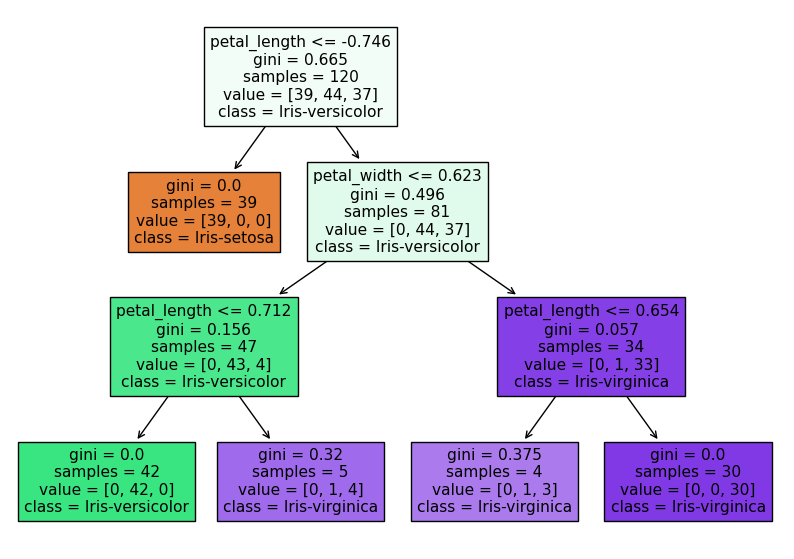

In [8]:
# Plot the decision tree
plt.figure(figsize=(10,7))
plot_tree(grid_search.best_estimator_.named_steps['clf'], 
          feature_names=iris.columns[:-1], 
          class_names=iris['class'].unique(), 
          filled=True)
plt.show()

## Feature Importance

In [9]:
# Get the feature importances
importance = grid_search.best_estimator_.named_steps['clf'].feature_importances_

# Print the importance of each feature
for i, feature in enumerate(X_train.columns):
    print(f"{feature}: {importance[i]}")

sepal_length: 0.0
sepal_width: 0.0
petal_length: 0.5965589377425896
petal_width: 0.4034410622574104


The importance score is calculated based on how much the feature decreases the impurity in the tree, which is typically measured using Gini impurity or entropy. A higher score means that the feature is more important in making accurate predictions. The score is normalized so that the sum of all scores is equal to 1. Therefore, the score of a feature indicates its relative importance among all features used in the model.

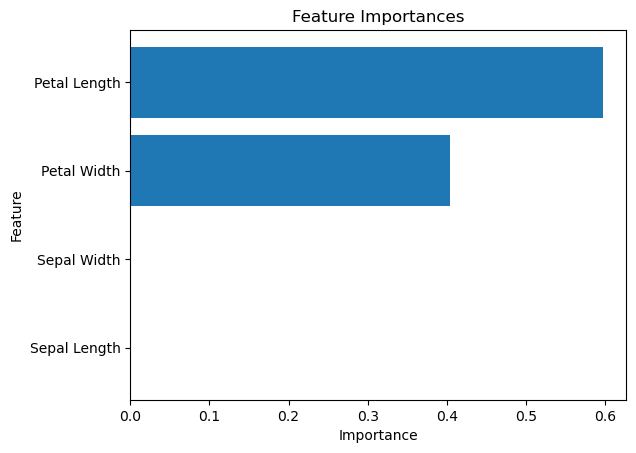

In [10]:
importance = grid_search.best_estimator_['clf'].feature_importances_
features = X_train.columns.tolist()

# create a dataframe to store feature importances
feat_importances = pd.DataFrame({'Feature': [word.title().replace('_'," ") for word in features], 
                                 'Importance': importance})

# sort features by importance in descending order
feat_importances = feat_importances.sort_values(by='Importance', ascending=True)

# plot feature importances horizontally
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

# Without Using Parameter Tuning

## Modules

In [1]:
import pandas as pd  
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

## Data

In [2]:
# Load the iris dataset from sklearn
iris = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', 
                   header=None, names=['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class'])
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
# Split the dataset into features and target variable
X = iris.drop('class', axis=1)
y = iris['class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# Feature scaling
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Training Model

In [4]:
# Train a decision tree classifier with regularization
clf = DecisionTreeClassifier(max_depth=2, min_samples_split=5, min_samples_leaf=2, max_features=4)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2, max_features=4, min_samples_leaf=2,
                       min_samples_split=5)

## Model Evaluation

In [5]:
# Predict on the test set and calculate accuracy
training_accuracy = accuracy_score(y_train, clf.predict(X_train))
y_pred = clf.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)

print(f'''\nTraining Accuracy: {round(training_accuracy*100, 2)}%
Prediction Accuracy: {round(testing_accuracy*100, 2)}%''')


Training Accuracy: 95.83%
Prediction Accuracy: 100.0%


In [6]:
print('\nConfusion matrix on testing data:')
print(confusion_matrix(y_test, y_pred))


Confusion matrix on testing data:
[[11  0  0]
 [ 0  6  0]
 [ 0  0 13]]


In [7]:
print('\nClassification report:')
print(classification_report(y_test, y_pred))


Classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        11
Iris-versicolor       1.00      1.00      1.00         6
 Iris-virginica       1.00      1.00      1.00        13

       accuracy                           1.00        30
      macro avg       1.00      1.00      1.00        30
   weighted avg       1.00      1.00      1.00        30



## Feature Importance

In [8]:
# Get the feature importances
importance = clf.feature_importances_
features = X.columns.tolist()
features = [word.title().replace('_'," ") for word in features]

# Print the importance of each feature
for i, feature in enumerate(features):
    print(f"{feature}: {importance[i]}")

Sepal Length: 0.0
Sepal Width: 0.0
Petal Length: 0.56131755625555
Petal Width: 0.43868244374445


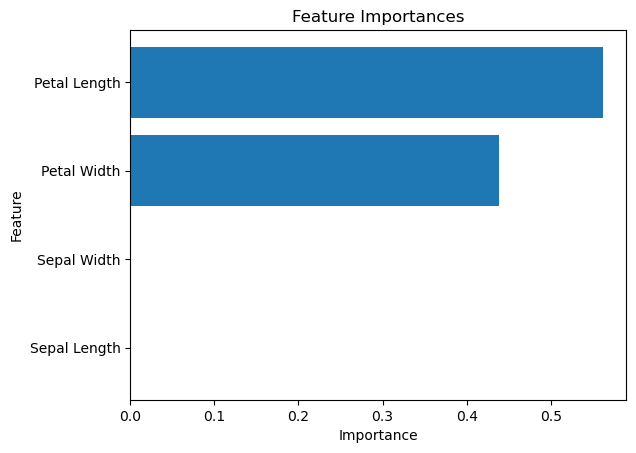

In [9]:
# create a dataframe to store feature importances
feat_importances = pd.DataFrame({'Feature': features, 
                                 'Importance': importance})

# sort features by importance in descending order
feat_importances = feat_importances.sort_values(by='Importance', ascending=True)

# plot feature importances horizontally
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

## Plotting Decision Tree

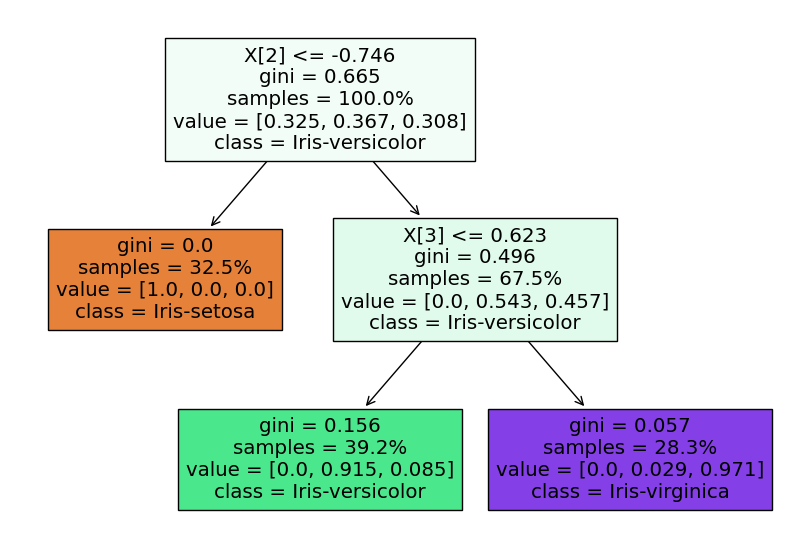

In [10]:
# plot the decision tree
plt.figure(figsize=(10, 7))
plot_tree(decision_tree=clf, filled=True, proportion=True, class_names=iris['class'].unique())
plt.show()

# Using Built in Iris Data

## Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report  

## Data

In [2]:
iris = load_iris()
X = iris.data
y = iris.target
print(type(iris))

<class 'sklearn.utils.Bunch'>


In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## Training Model

In [4]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

## Model Evaluation

In [5]:
# Predict and calculate accuracy
training_accuracy = accuracy_score(y_train, clf.predict(X_train))

y_pred = clf.predict(X_test)
testing_accuracy = accuracy_score(y_test, y_pred)

print(f'''\nTraining Accuracy: {round(training_accuracy*100, 2)}%
Prediction Accuracy: {round(testing_accuracy*100, 2)}%''')


Training Accuracy: 95.83%
Prediction Accuracy: 96.67%


In [6]:
print('\nClassification report:')
print(classification_report(y_test, y_pred,target_names=iris.target_names))


Classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.90      1.00      0.95         9
   virginica       1.00      0.91      0.95        11

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



## Plotting Decision Tree

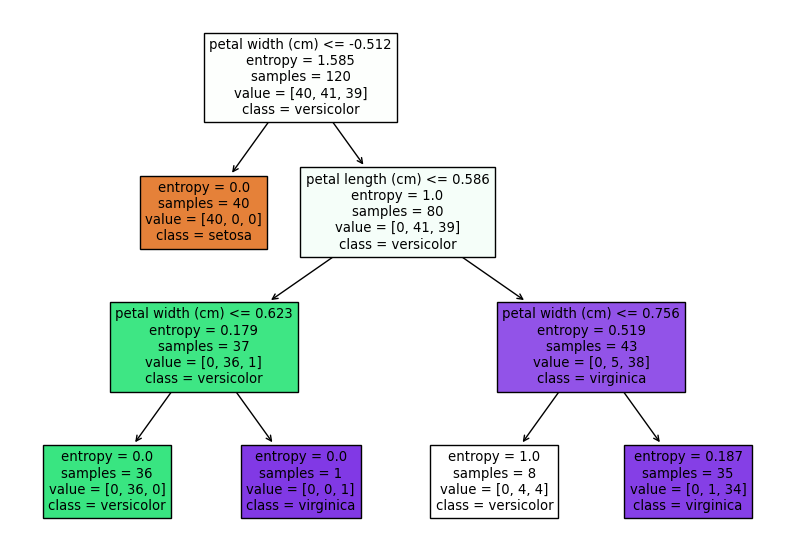

In [7]:
plt.figure(figsize=(10, 7))
plot_tree(clf, filled=True, feature_names=iris.feature_names, class_names=iris.target_names)
plt.show()

In [8]:
# Get the feature importances
importance = clf.feature_importances_

# Print the importance of each feature
for i, feature in enumerate(iris.feature_names):
    print(f"{feature}: {importance[i]}")

sepal length (cm): 0.0
sepal width (cm): 0.0
petal length (cm): 0.29060680820947116
petal width (cm): 0.7093931917905287


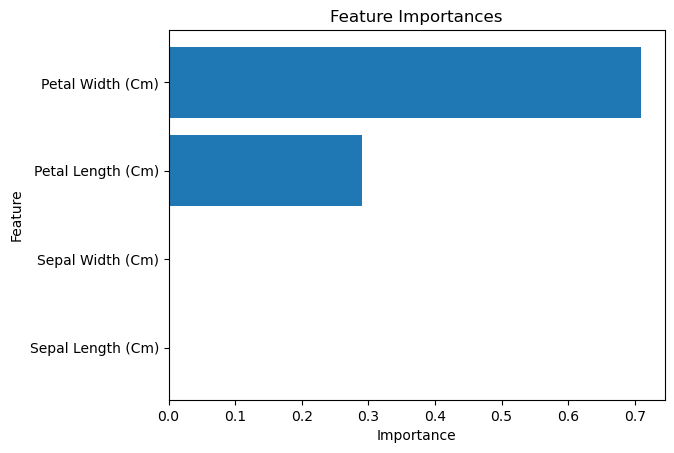

In [9]:
importance = clf.feature_importances_
features = iris.feature_names

# create a dataframe to store feature importances
feat_importances = pd.DataFrame({'Feature': [word.title().replace('_'," ") for word in features], 
                                 'Importance': importance})

# sort features by importance in descending order
feat_importances = feat_importances.sort_values(by='Importance', ascending=True)

# plot feature importances horizontally
plt.barh(feat_importances['Feature'], feat_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()